***
# <font color=lightblue size=10>Gradient Descent</font>
***


Nesta aula, utilizaremos exercícios práticos para compreender o funcionamento do algoritmo gradient descent.

# Importando Bibliotecas

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Regressão Linear - Revisão

Quando tentamos resolver um problema prático com estatística, o que buscamos fazer é criar modelo que, ao receber um conjunto de informações externas, nos de uma resposta certa. Com outras palavras, o que desejamos é criar uma função que possua um conjunto de parâmetros de modo que, ao receber um certo conjunto de valores de entrada, nos de uma resposta certa para um dado problema. Dentro do contexto de regressão linear, não é diferente.

Um modelo linear pode ser expressado pela seguinte equação:

> $ \hat{y} = Xw + b $,

Desse modo, quando queremos resolver um problema com regressão linear, o que queremos é essecialmente escolher os melhores parâmetros para esta função para que o erro dela seja mínimo.

Para que voçê possa entender melhor, vamos fazer um pequeno exercício. Vamos considerar que temos 4 residências com as seguintes informações:
* [área]  X = (50,60,70,80) metros quadrados;
* [valor] y =(100,120,140,160) mil reais.

Nosso objetivo é  criar um modelo que tem como entrada as informações de área e a saída é o valor do imóvel. Ao rodar a célula abaixo você verá barras com nomes dos coeficientes de **w** e **b**, ao movê-las podemos ajustar a reta até que ela se aproxime do valor ideal.


✅ Sua tarefa é ajustar esses coeficientes e informar os melhores valores para que o modelo obtenha um bom desempenho.

In [9]:
from ipywidgets import interact

X = np.array([50,60,70,80])
y = np.array([100,120,140,160])

@interact(w = (1.0,3.0,0.1), b=(0,5,1))
def regression(w, b):
    resultado = X*w + b

    idx = y.argsort()
    plt.plot(y,y)
    plt.plot(resultado[idx], y[idx], 'r.');
    plt.title(f'Ajuste dos parâmetros\nw = {w}\nb = {b}', size=14)
    plt.xlabel('Altura prevista', size=14)
    plt.ylabel('Altura Real', size=14)

interactive(children=(FloatSlider(value=2.0, description='w', max=3.0, min=1.0), IntSlider(value=2, descriptio…

Além disso, além de escolher um conjunto de parâmetros, como voçê fez no exercício acima, precisamos de um modo de avaliar o desempenho do modelo com os parâmetros escolhidos. Para isso utilizamos funções de perda, que também são conhecidas como funções **Loss**. No caso exercício anterior, **o objetivo seria ajustar os valores dos parâmetros (w) e bias (b) para nossas predições $(\hat{y})$ aproximarem o máximo possível do valor esperado ($y$) e, assim, o valor da função de perda ser mínimo**.

Funções de perda nos permitem avaliar o desempenho de um modelo de forma quantitativa, podemos obter um valor que demonstra o quão distante nosso modelo está em relação ao valor esperado. Para a regressão linear, vamos analisar a função de perda do erro médio quadrático, apresentada a seguir:

> $ MSE = \frac{1}{m} \sum\limits_{i=1}^{m} \mathcal{L}(\hat{y}^{(i)}, y^{(i)})^{2} = \frac{1}{m} \sum\limits_{i=1}^{m} (\hat{y}, y)^{2} $

Levando em consideração a função de perda, utilize o código interativo abaixo para visualizar a reta gerada, agora juntamente com o valor da função loss. Voçê conseguiu encontrar o conjunto de parâmetros que gera o menor erro?

In [10]:
def loss_func(X, y, w, b):

    # inicializando variáveis
    loss = None
    m = len(y)

    # predição
    y_pred = X*w + b

    # função de custo
    loss = (1/m) * np.sum((y_pred - y)**2)
    return loss

@interact(w = (1.0,3.0,0.1), b=(0,5,1))
def regression(w, b):
    resultado = X*w + b
    loss = loss_func(X, y, w, b)
    idx = y.argsort()
    plt.plot(y,y)
    plt.plot(resultado[idx], y[idx], 'r.');
    plt.title(f'Ajuste dos parâmetros\nw = {w}\nb = {b}\nloss = {loss}', size=14)
    plt.xlabel('Altura prevista', size=14)
    plt.ylabel('Altura Real', size=14)

interactive(children=(FloatSlider(value=2.0, description='w', max=3.0, min=1.0), IntSlider(value=2, descriptio…

Como você pode entender, desejamos achar o conjunto de parâmetros para um modelo que gere o menor erro possível da função de perda. Em casos simples, é possível achar o melhor modelo usando apenas cálculo analítico, isto é, utilizando derivadas, igualação a zero e resolução de equações. Contudo, embora esta abordagem funcione bem com em funções simples e com poucos parâmetros, ela se torna impraticável quando lidamos com funções complexas, não lineares e de alta dimensão, como as que aparecem em modelos de aprendizado de máquina.

Por exemplo, em uma rede neural com milhares ou milhões de parâmetros, a função de custo pode envolver uma combinação intricada de operações não lineares, como funções de ativação (ReLU, sigmoid, etc.), que tornam a expressão da função muito difícil ou impossível de resolver simbolicamente. Mesmo que fosse possível derivar uma equação, o sistema resultante de equações simultâneas seria gigantesco e quase impossível de resolver com métodos puramente matemáticos.

Por causa deste desafio, foi desenvolvida a técnica de ciência de dados **'Gradient Descent'**, que é um método iterativo e numérico, que permite aproximar a solução pouco a pouco, mesmo quando a forma da função é muito complicada.

# A Ideia do Gradient Descent

O **Gradient Descent** é um algoritmo de otimização que serve para **minimizar funções**, ele é o algoritmo base da maioria dos __frameworks__ de aprendizado de máquina para a tarefa de minimizar o valor das funções de perda.

A intuição do algoritmo é a seguinte: Imagine que você está no topo de uma montanha (valor alto da função de custo) e quer descer até o ponto mais baixo (mínimo).Você calcula a **inclinação local** (o gradiente) e dá um passo **na direção contrária da inclinação**. Quanto mais inclinado, maior o passo. Com o tempo, você chega no fundo do vale (mínimo da função).

## Etapas do Algoritmo (Considerando o Contexto de Regressão Linear)

1. **Inicialize** os parâmetros `w` e `b` com valores quaisquer (ex: 0 ou aleatórios)
2. **Calcule as previsões**:  
   $$
   \hat{y} = wX + b
   $$
3. **Calcule a função de custo** $$ J(w, b) $$
4. **Calcule os gradientes** (derivadas parciais):

$$
\frac{\partial J}{\partial w} = \frac{-2}{m} \sum_{i=1}^{m} x_i (y_i - \hat{y}_i)
$$
$$
\frac{\partial J}{\partial b} = \frac{-2}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)
$$

5. **Atualize os parâmetros** usando os gradientes:

$$
w := w - \alpha \frac{\partial J}{\partial w}
\quad \text{e} \quad
b := b - \alpha \frac{\partial J}{\partial b}
$$

Onde `α` (alfa) é a **taxa de aprendizado**, que controla o tamanho do passo.

6. **Repita** os passos 2 a 5 até a convergência (ou por um número fixo de iterações).


In [11]:
def prediction(X, w):
    return np.dot(w.T, X)

def loss_func(y_pred, y):
    m = len(y)
    return (1/m) * np.sum((y_pred - y)**2)

def gradient_calc(X, y, y_pred):
    m = len(y)
    return (2/m) * np.dot(X, (y_pred - y).T)

def gradient_descent(X, y, learning_rate = 0.01, iterations=100):
    """
    Cálculo do grandiente descendente

    Parâmetros:
        X [np.array]: matriz com os valores de X
        y [np.array]: vetor com os valores de y
        w [np.array]: vetor de pesos aleatórios
        learning_rate [float]: valor da taxa de aprendizado
        iterations    [int]: quantidade de iterações

    Retorna o melhor vetor de pesos e os valores de custo e dos pesos em cada iteração
    """

    # inicializando as variáveis
    m = len(y)
    J_history = []
    w_history = []

    ones = np.ones((1, X.shape[1]))
    X = np.append(ones, X, axis=0)         # add bias no primeiro valor do vetor X >> X0 = 1
    w = np.random.randn(X.shape[0])

    for iteration in range(iterations):


        y_pred = prediction(w, X)                         # predição
        loss = loss_func(y_pred, y)                       # perda
        calculo_gradiente = gradient_calc(X, y, y_pred)   # cálculo dos gradientes
        w = w - learning_rate * calculo_gradiente         # atualizando os pesos e calculando a perda

        w_history.append(w)     # armazenando os pesos em uma lista
        J_history.append(loss)  # armazenando as perdas em uma lista

    # retorna um dicionário contendo o peso atual, o histórico de pesos e perdas.
    return {
        'w': w,
        'w_hist': w_history,
        'J_hist': J_history
        }

# Regressão utilizando dados sintéticos

Agora, utilizaremos dados gerados sintéticamente para visualizar o funcionamento do algoritmo de gradiente descendente. Nas células abaixo, como a função de perda e a evolução dos pesos se comportam com diferentes escolhas de 'learning rate' e iterações.  

In [12]:
def plot_history(results):
    import matplotlib.pyplot as plt
    import numpy as np

    J_hist = results['J_hist']
    w_hist = np.array(results['w_hist'])  # Converte lista de vetores para array (iterações x número de pesos)

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico da função de custo
    axs[0].plot(J_hist, 'r-')
    axs[0].set_title('Função de Perda (J)', fontsize=15)
    axs[0].set_xlabel('Iterações', fontsize=12)
    axs[0].set_ylabel('Custo', fontsize=12)
    axs[0].grid(True)

    # Gráfico dos pesos
    for i in range(w_hist.shape[1]):
        axs[1].plot(w_hist[:, i], label=f'w[{i}]', alpha=0.6)

    axs[1].set_title('Evolução dos Pesos', fontsize=15)
    axs[1].set_xlabel('Iterações', fontsize=12)
    axs[1].set_ylabel('Valor do Peso', fontsize=12)
    axs[1].legend(loc='best', ncol=2, fontsize=8)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


# Teste com diferentes hiperparâmetros de 'learning rate' e número iterações

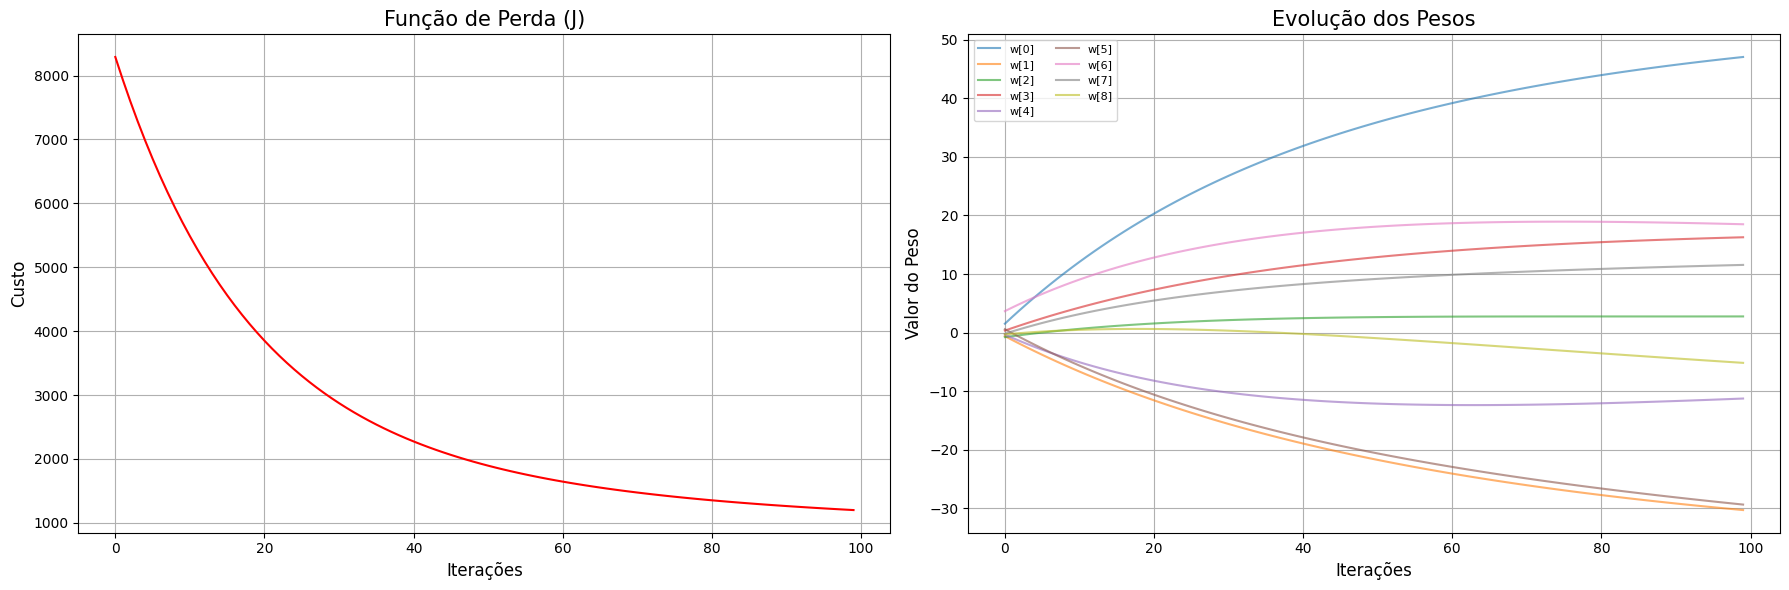

In [13]:
samples = 8
X, y = make_regression(n_samples=samples, n_features=samples, random_state=10)
results = gradient_descent(X, y, learning_rate = 0.01, iterations=100)
plot_history(results)

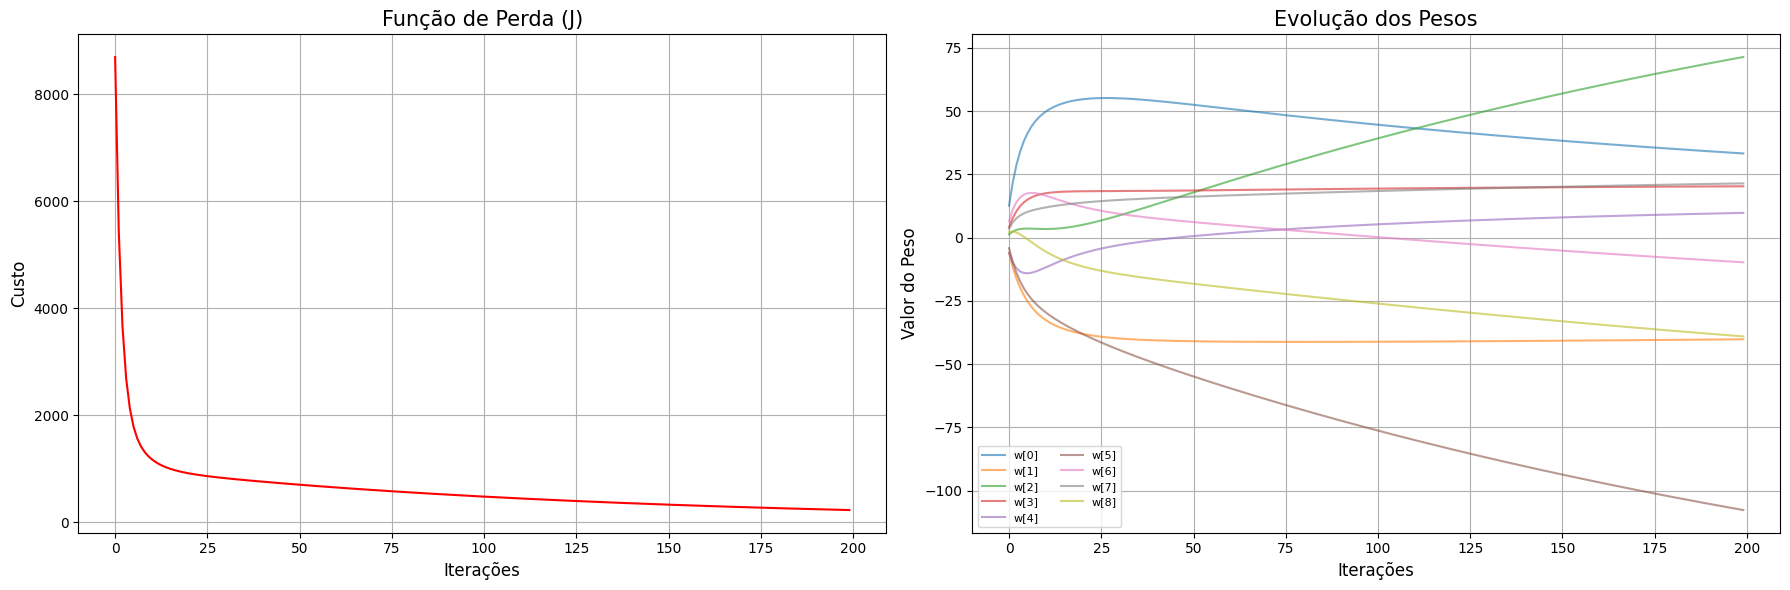

In [14]:
samples = 8
X, y = make_regression(n_samples=samples, n_features=samples, random_state=10)
results = gradient_descent(X, y, learning_rate = 0.1, iterations=200)
plot_history(results)

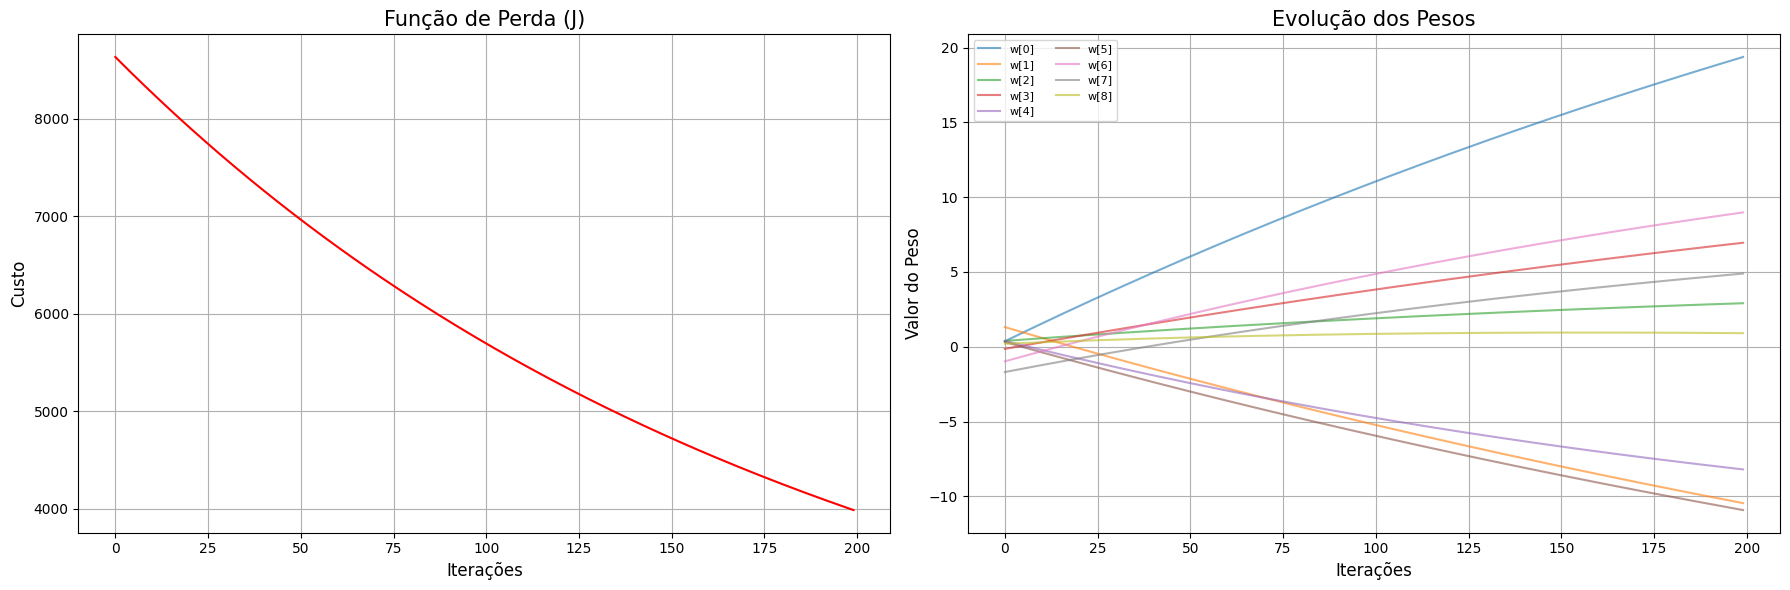

In [15]:
samples = 8
X, y = make_regression(n_samples=samples, n_features=samples, random_state=10)
results = gradient_descent(X, y, learning_rate = 0.001, iterations=200)
plot_history(results)

Aumente a quantidade de iterações e comente sobre o que percebeu

In [16]:
# COLOQUE SEU CÓDIGO AQUI
#
#
#

Agora, experimente alterar o valor da taxa de aprendizado. Você irá perceber que quanto maior o valor, mais rápido o modelo tende a convergir.

In [17]:
# COLOQUE SEU CÓDIGO AQUI
#
#
#

# Visualização do Gradient Descent em Modelos de Redes Neurais

## Baixando Dados

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



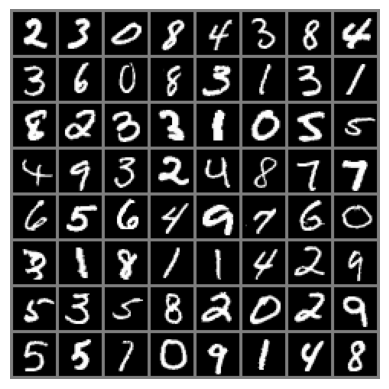

Labels: 2 3 0 8 4 3 8 4 3 6 0 8 3 1 3 1 8 2 3 3 1 0 5 5 4 9 3 2 4 8 7 7 6 5 6 4 9 7 6 0 3 1 8 1 1 4 2 9 5 3 5 8 2 0 2 9 5 5 7 0 9 1 4 8


In [19]:
# --- Transformações ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Dataset ---
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# --- Plot de Imagens ---
def imshow(img):
    img = img / 2 + 0.5  # desfaz a normalização (de [-1,1] para [0,1])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.axis("off")
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:64], nrow=8))
print("Labels:", ' '.join(f'{labels[j].item()}' for j in range(64)))


## Definindo Modelo de CNN

In [20]:
# --- Modelo ---
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Treino e Teste

Execute o código de treinamento abaixo e perceba que, a cada época (etapa em que a rede neural processa um conjunto de dados e se atualiza), o erro (função Loss) diminui e a acurácia (taxa de acerto) aumenta. Isto é justamente o processo de gradient descent em andamento.

Treinando em: cuda
[Época 1] Loss: 0.1700 | Acurácia: 98.09%
[Época 2] Loss: 0.0498 | Acurácia: 98.79%
[Época 3] Loss: 0.0321 | Acurácia: 98.89%
[Época 4] Loss: 0.0252 | Acurácia: 98.97%
[Época 5] Loss: 0.0186 | Acurácia: 99.17%
Treinamento finalizado!


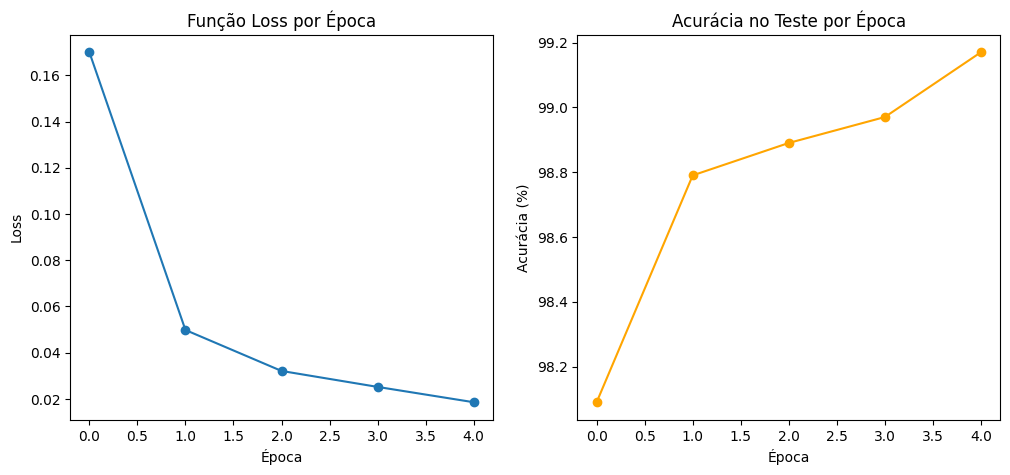

In [21]:
# --- Treinamento ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Treinando em:", device)

net = MNIST_CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 5
train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    # --- Avaliação na época ---
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    test_accuracies.append(acc)

    print(f"[Época {epoch+1}] Loss: {avg_loss:.4f} | Acurácia: {acc:.2f}%")

print("Treinamento finalizado!")

# --- Plotar gráficos ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Função Loss por Época")
plt.xlabel("Época")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies, marker='o', color='orange')
plt.title("Acurácia no Teste por Época")
plt.xlabel("Época")
plt.ylabel("Acurácia (%)")

plt.show()